## Fitting the proton content with a quantum circuit

<center><img src="../../figures/qibo_mascotte/qibo_qpdf.png" alt="drawing" width="400"/></center>
<center> Qibo fitting the proton content with a quantum computer [DALL-E].</center>

#### Introduction

In the following we get familiar with Parametric Quantum Circuits (PQC) and then train a PQC to perform a simple one dimensional fit. In particular we aim to approximate the *up* quark Parton Distribution Function (PDF).

---

<center><img src="./figures/proton_pdf.png" alt="drawing" width="400"/></center>
<center> Proton PDFs from the NNPDF collaboration.</center>

$$~$$ 

Given a proton, composed of partons, the parton distribution function $u_i\,f_i(x)$ of a specific parton $p_i$ is the probability that $p_i$ can be found at a certain energy scale $x$.

For us, it will be a simple one dimensional function which we aim to approximate.

---

#### We can start with some imports

In [1]:
# plotting and numerics
import matplotlib.pyplot as plt
import numpy as np

# qibo modules/features
import qibo
from qibo import Circuit, gates, hamiltonians
from qibo.optimizers import optimize

# This will be useful to plot the target with our predictions
from qiboedu.scripts.plotscripts import plot_target, visualize_states

In this notebook we will set the `numpy` backend, but all the available backends can be visualized using a dedicated qibo function.

In [2]:
# if we want to have a look to all the supported backends
qibo.list_available_backends()

{'numpy': True, 'qulacs': True}

In [3]:
# set qibo backend depending on your problem
qibo.set_backend(backend="numpy")

[Qibo 0.2.15|INFO|2025-01-16 15:31:57]: Using numpy backend on /CPU:0


### Parametric quantum circuits

We can build parametric quantum circuit, using gates which depend on some parameter (in case you need more introductory material to get practice with qibo basics, we reccomend to explore some of the lectures provided in `Qiboedu`). 

The most used parametric gates are rotations: $R_k = \exp [-i\theta \sigma_k]$, which are parametric through the rotation angle $\theta$ and are generated by the Pauli operators $\sigma_k$ ($k$ here is $x, y$ or $z$).

In [4]:
def build_parametric_circuit(nlayers):
    """Construct the scheleton of the parametric quantum circuit repeating a schema `nlayers` times."""
    c = Circuit(1)
    for _ in range(nlayers):
        c.add(gates.RY(q=0, theta=0.))
        c.add(gates.RZ(q=0, theta=0.))
    c.add(gates.M(0))
    return c

We can print some information about the parametric quantum circuit.

In [5]:
pqc = build_parametric_circuit(nlayers=3)
pqc.draw()
print("\n", pqc.summary())

0: ─RY─RZ─RY─RZ─RY─RZ─M─

 Circuit depth = 7
Total number of gates = 7
Number of qubits = 1
Most common gates:
ry: 3
rz: 3
measure: 1


#### Manipulating circuit's parameters

We can access to circuit's parameters using the `circuit.get_parameters` method and similarly we can update their values using the `circuit.set_parameters` method.

Since we initialized the circuit setting every $\theta$ to be equal to zero, we expect this circuit to not act on the initial state.

In [6]:
# we set them to be zero!
print(pqc.get_parameters())

[(0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,)]


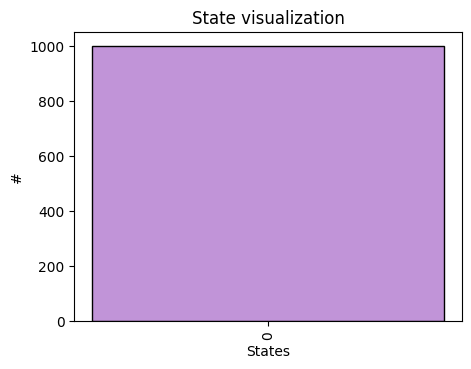

In [7]:
# and thus we expect them to do nothing on the ground state
visualize_states(pqc(nshots=1000).frequencies())

If now we change the parameters values randomly, e.g. generating random numbers using Numpy, we expect the state to move from $|0\rangle$ to a superposition of the two computational basis vectors.

In [8]:
# generating new parameters values
np.random.seed(42)
nparams = len(pqc.get_parameters())
new_parameters = np.random.randn(nparams)

# injecting them into the circuit
pqc.set_parameters(new_parameters)
print(pqc.get_parameters())

[(0.4967141530112327,), (-0.13826430117118466,), (0.6476885381006925,), (1.5230298564080254,), (-0.23415337472333597,), (-0.23413695694918055,)]


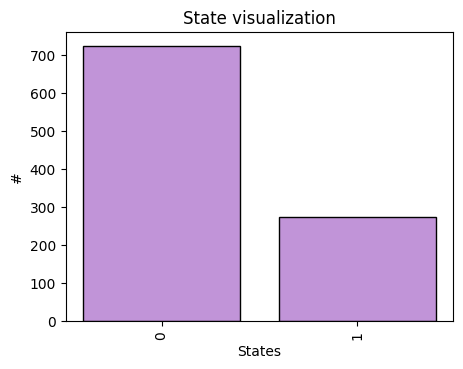

In [9]:
# plotting the frequencies
visualize_states(pqc(nshots=1000).frequencies())

### Training a parametric circuit to fit a PDF

Now we need to combine everything together building a simple quantum machine learning pipeline to handle a target problem. To get a schematic introduction of a typical quantum machine learning pipeline, you can have a look to the following figure. 
<center><img src="./figures/qml_simplified.svg" alt="drawing" width="800"/></center>
In practice, the idea is to define a parametric quantum circuit, and to use it to prepare a variational state (you just execute the circuit given a set of parameters). This state is then used to compute the expectation value of a target observable, which can be decided according to your needs. Finally we can use some optimization algorithm to find an optimal set of parameters for our circuit. Namely, a set of parameters such that the expectation value of the target observable over the prepared state matches the target. 

$$~$$

**But how a single circuit can be used to fit an entire function domain?**
The parametric gates of a quantum circuit can be used also to encode external input data! In practice, some of the gates are used as parametric pieces of the model, while other gates can be used instead ad containers for external data. Betterm we can define some circuit's parameters as a combination of data and trainable parameters, e.g. $\theta = \alpha \cdot x + \beta$. 

If so, the circuit is trained on a training set of points! For each input data we compute our predictions, following a typical machine learning pipeline.

#### Data preparation for our use case

At first, we need to prepare the training data. We will use data from the NNPDF 4.0 grid as labels.

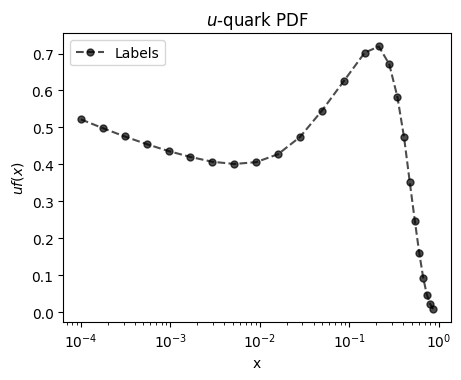

In [10]:
# load data
data = np.loadtxt("data/u.dat")

x_data = data.T[0]
labels = data.T[1]

indexes = np.arange(0, len(labels), 4)
x_data = x_data[indexes]
labels = labels[indexes]

# plot training data
plot_target(x_data, labels)

Then we need to define a schema to upload the input data into the quantum circuit together with some variational parameters. For this, we define the following `set_parameters` function.

In [11]:
def set_parameters(circuit, nlayers, parameters, x):
    """
    Upload data and trainable parameters into a circuit.
    We want to combine data and params so that angle = p1 * x + p2
    """
    params = []
    index = 0
    for _ in range(nlayers):
        params.append(parameters[index] * x + parameters[index + 1])
        params.append(parameters[index + 2] * np.log(x) + parameters[index + 3])
        index += 4
    circuit.set_parameters(params)
    return circuit

Then, we need a function to compute predictions for all the points of the training set. We are going to call it `predict` and we make use of the expectation function of a target observable to compute the predictions. In particular, since the PDF are defined into [0,1], we use a non interacting Pauli Z as observable: 
$$ Z = \begin{bmatrix} 1 & 0 \\ 0 & -1 \end{bmatrix}.$$
Whose expectation value is defined in [-1,1].

In [12]:
# predictions
def predict(parameters, data, nlayers, circuit, hamiltonian):
    """Compute predictions given dataset and parameters."""
    predictions = []
    for x in data:
        circuit = set_parameters(circuit, nlayers, parameters, x)
        predictions.append(hamiltonian.expectation(circuit().state()))
    return predictions

We also need a loss function to quantify the goodness of our predictions! We can choose a Mean-Squared Error (MSE) loss function:
$$ MSE = \frac{1}{M} \sum_{i=1}^M \bigl[ E_{\vec{\theta}}(x_i) - y_i\bigr]^2, $$
where our prediction $E_{\vec{\theta}}(x_i)$ is the expected value of $Z$ over the state we get executing the circuit in which we inject both $\vec{\theta}$ and $x_i$, while $y_i$ is the NNPDF label associated to the input value $x_i$.

In [13]:
def loss_function(parameters, data, labels, circuit, nlayers, hamiltonian):
    """Compute loss function considering all data and a given set of parameters."""
    loss = 0
    predictions = predict(parameters, data, nlayers, circuit, hamiltonian)
    for i, pred in enumerate(predictions):
        loss += (pred - labels[i])**2
    return loss / len(labels)

We can now define a number of layers and set up the training.

In [14]:
# define the parametric quantum circuit
nlayers = 4
pqc = build_parametric_circuit(nlayers)

np.random.seed(42)
initial_parameters = np.random.randn(nlayers * 4)
pqc = set_parameters(pqc, nlayers, initial_parameters, 0.3)

# define the observable
h = hamiltonians.Z(nqubits=1)

In [15]:
pqc.draw()

0: ─RY─RZ─RY─RZ─RY─RZ─RY─RZ─M─


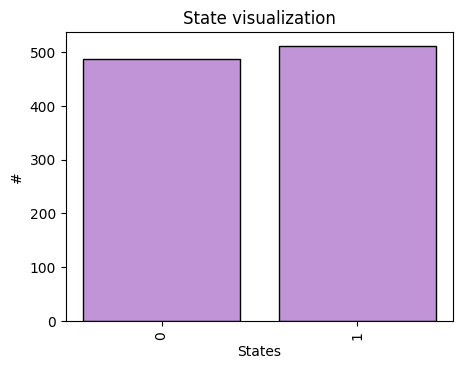

In [16]:
visualize_states(pqc(nshots=1000).frequencies())

We can have a look to the initial prediction of the model, which are expected to be random (not well predicting).

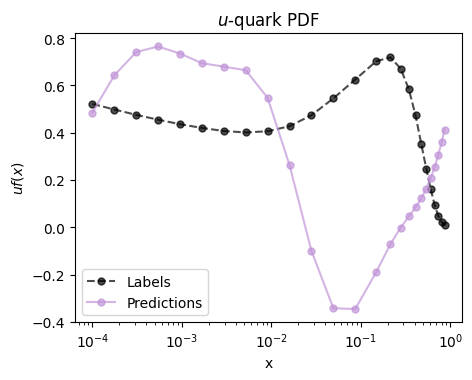

In [17]:
predictions = predict(initial_parameters, x_data, nlayers, pqc, h)
plot_target(x_data, labels, predictions)

The final element we need is the choice of the optimizer. What we need is an algorithm to which we delegate the updating of the parameters. We will use a Genetic Algorithm, in particular the Covariance Matrix Adaptation Evolution Strategy. This, among many other optimizers, can be used calling the `qibo.optimizers.optimize` function setting `method="cma"`.  

In [18]:
# THIS CELL COULD REQUIRE A COUPLE OF MINUTES OF TIME TO BE EXECUTED
optimization_result = optimize(
    loss_function, 
    initial_parameters=initial_parameters, 
    method="cma", 
    args=(x_data, labels, pqc, nlayers, h), 
    options={"maxiter": 1500}
)

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 16 (seed=147340, Thu Jan 16 15:31:59 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 2.123419862853609e-01 1.0e+00 1.54e+00  2e+00  2e+00 0:00.1
    2     24 8.767990372199856e-02 1.1e+00 1.50e+00  1e+00  2e+00 0:00.2
    3     36 3.120292548482150e-01 1.2e+00 1.48e+00  1e+00  2e+00 0:00.3
   48    576 2.444131294909818e-01 2.5e+00 1.29e+00  1e+00  1e+00 0:03.3
  100   1200 5.658723977337442e-02 3.2e+00 3.55e-01  2e-01  4e-01 0:06.9
  174   2088 1.881589059441245e-03 4.7e+00 7.57e-02  3e-02  9e-02 0:11.9
  200   2400 5.278536694578110e-04 7.0e+00 2.77e-02  1e-02  3e-02 0:13.7
  300   3600 1.034124016687003e-04 2.1e+01 2.05e-02  4e-03  3e-02 0:20.5
  400   4800 1.377526688543876e-05 5.8e+01 1.17e-02  1e-03  2e-02 0:27.3
  500   6000 4.976242276001162e-06 2.1e+02 9.05e-03  6e-04  3e-02 0:34.1
  600   7200 2.857989492080359e-06 4.0e+02 5.60e-03  3e-04  2e-02 0:40.9
  700   8400 2.273544835230191e-0

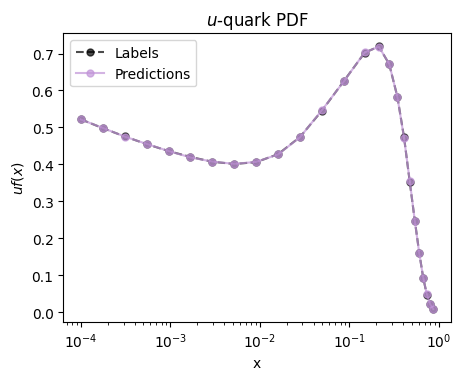

In [19]:
best_params = optimization_result[1]
predictions = predict(best_params, x_data, nlayers, pqc, h)
plot_target(x_data, labels, predictions)